In [4]:
import numpy as np
import matplotlib.pyplot as plt
from cpymad.madx import Madx
import pandas as pd
from pybt.tools.plotters import *
from madxtools.plot_tool import *

In [5]:
gamma = 25.598474067
beta = np.sqrt(1-gamma**(-2))
exn = 4.92e-06
eyn = 3.4e-06
sige = 0.000412
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
Brho = 24*3.3356

# Matched initial parameters
betx0 = 154.0835045206266
bety0 = 5.222566527078791
alfx0 = -36.90472944993891
alfy0 = 0.2523074897915478
Dx0 = 0.13
Dy0 = 0.0
Dpx0 = 0.02
Dpy0 = 0.0
exn = 7.639770207283603e-06
eyn =  3.534081877201574e-06
sige = 0.000679081344780741

with open('tempfile', 'w') as f:
    madx = Madx(stdout=f,stderr=f)
    madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

madx.input('''

QF : QUADRUPOLE, L = 2, APERTYPE=CIRCLE, APERTURE={0.025};
QD : QUADRUPOLE, L = 2, APERTYPE=CIRCLE, APERTURE={0.025};


QF1 : QF, K1 := kQF1;
QD2 : QD, K1 := kQD2;
QF3 : QF, K1 := kQF3;
QD4 : QD, K1 := kQD4;

kQF1 = 0.4;
kQD2 = -0.5;
kQF3 = 0.2;
kQD4 = -0.5;

simple_seq: SEQUENCE, refer = exit, l = 100;
QF1 : QF1, AT=2;
QD2 : QD2, AT=5;
QF3 : QF3, AT=8;
QD4 : QD4, AT=11;
ENDSEQUENCE;
''')

ex = exn/(beta*gamma)
ex_0 = ex
ey = eyn/(beta*gamma)

madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
madx.input('BRHO      := BEAM->PC * 3.3356;')

madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
madx.use(sequence="simple_seq")
twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

Text(0, 0.5, '$\\beta$ [m]')

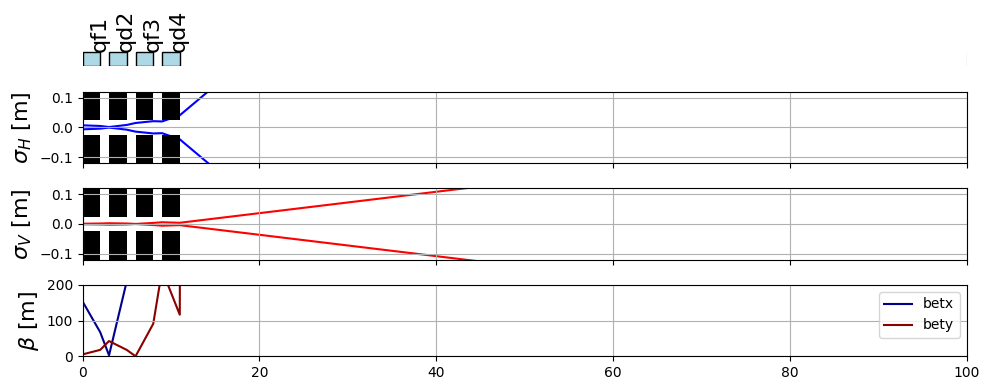

In [6]:
fontsize = 16

fig, ax = plt.subplots(4,1, figsize=(10,4), tight_layout=True, sharex=True, height_ratios=[1,3,3,3])

draw_synoptic(ax[0], twiss)
ax[0].set_xlim(0,twiss.s[-1])
ax[0].set_ylim(-0.02,1.)
ax[0].axis("off")

ax[1].plot(twiss['s'], beam_size(twiss['betx'], twiss['dx'], ex, sige, 1)+twiss.x, alpha=1.0, color ="b", zorder=0)
ax[1].plot(twiss['s'], -beam_size(twiss['betx'], twiss['dx'], ex, sige, 1)+twiss.x, alpha=1.0, color ="b", zorder=0)
draw_aperture_circle(ax[1], twiss, "aper_1")
draw_aperture_rectangle(ax[1], twiss, "aper_1")
ax[1].set_xlim(0,twiss.s[-1])

ax[2].plot(twiss['s'], beam_size(twiss['bety'], twiss['dy'], ey, sige, 1)+twiss.y, alpha=1.0, color ="r", zorder=0)
ax[2].plot(twiss['s'], -beam_size(twiss['bety'], twiss['dy'], ey, sige, 1)+twiss.y, alpha=1.0, color ="r", zorder=0)
draw_aperture_circle(ax[2], twiss, "aper_1")
draw_aperture_rectangle(ax[2], twiss, "aper_2")
ax[2].set_xlim(0,twiss.s[-1])

ax[1].grid()
ax[1].set_ylim(-0.12, 0.12)
ax[1].set_ylabel(r"$\sigma_{H}$ [m]", fontsize=fontsize)

ax[2].grid()
ax[2].set_ylim(-0.12, 0.12)
ax[2].set_ylabel(r"$\sigma_{V}$ [m]", fontsize=fontsize)

# Beta
ax[3].plot(twiss.s, twiss.betx, alpha=1.0, color ="darkblue", zorder=0, label="betx")
ax[3].plot(twiss.s, twiss.bety, alpha=1.0, color ="darkred", zorder=0, label="bety")
ax[3].set_xlim(0,twiss.s[-1])

ax[3].legend()
ax[3].set_ylim(0, 200)
ax[3].grid()
ax[3].set_ylabel(r"$\beta$ [m]", fontsize=fontsize)

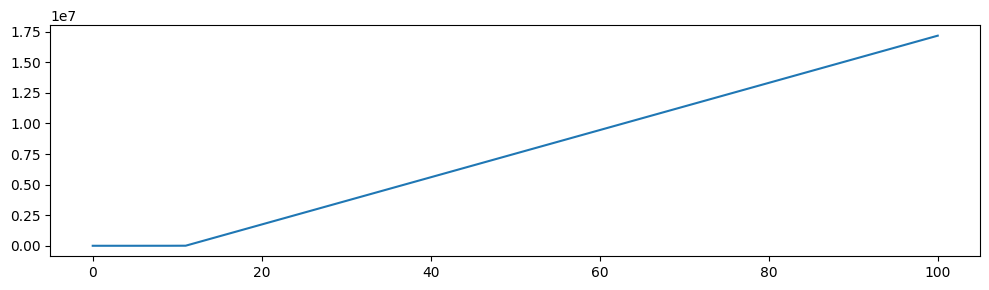

In [7]:
fig, ax = plt.subplots(figsize=(10,3), tight_layout=True)
ax.plot(twiss.s, twiss.betx)

In [8]:
twiss.betx.cumsum()[-1]

34371572.200734355

In [9]:
import pybobyqa

# Define the objective function
def f_beam_size(params):
    print(params)
    kQF1, kQD2, kQF3, kQD4 = params

    madx.input("kQF1 = "+str(kQF1)+";")
    madx.input("kQD2 = "+str(kQD2)+";")
    madx.input("kQF3 = "+str(kQF3)+";")
    madx.input("kQD4 = "+str(kQD4)+";")
    twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

    minimize_beta = twiss.betx.cumsum()[-1]**2 + twiss.bety.cumsum()[-1]**2

    
    objective = minimize_beta
    print (objective)
    return (objective)

# Define the starting point
initial_guess = np.array([0.5, -0.2, 0.5, -0.2])

# Call Py-BOBYQA (with bounds)
soln = pybobyqa.solve(f_beam_size, initial_guess, rhobeg = 0.05, seek_global_minimum=False, maxfun=500)

print(soln)

[ 0.5 -0.2  0.5 -0.2]
248654265394845.34
[ 0.55 -0.2   0.5  -0.2 ]
483380850917088.2
[ 0.5  -0.15  0.5  -0.2 ]
206960189564084.66
[ 0.5  -0.2   0.55 -0.2 ]
486932045921942.06
[ 0.5  -0.2   0.5  -0.15]
182211856435846.4
[ 0.45 -0.2   0.5  -0.2 ]
104660187801260.42
[ 0.5  -0.25  0.5  -0.2 ]
297771437994103.94
[ 0.5  -0.2   0.45 -0.2 ]
103479798377131.3
[ 0.5  -0.2   0.5  -0.25]
334901101110478.6
[ 0.46178578 -0.18644585  0.43036865 -0.17830741]
31163090743735.914
[ 0.4371665  -0.17494047  0.46625702 -0.15654638]
33676547459252.64
[ 0.44714065 -0.19603726  0.44186268 -0.19196071]
32184211278163.55
[ 0.4520633  -0.18541708  0.42465709 -0.17615366]
22328116564494.918
[ 0.44102078 -0.19006812  0.42195314 -0.17847081]
16822774925965.283
[ 0.43468902 -0.18270511  0.42051076 -0.18620803]
14091728905758.293
[ 0.42282112 -0.17919118  0.42185311 -0.18732756]
10866690730680.037
[ 0.4064429  -0.16125372  0.44312042 -0.14914769]
9741959420215.168
[ 0.40087854 -0.15639874  0.46368785 -0.10417605]
9867

In [12]:
soln.x

array([ 0.32730047, -0.36102915,  0.32789126, -0.1991137 ])

Text(0, 0.5, '$\\beta$ [m]')

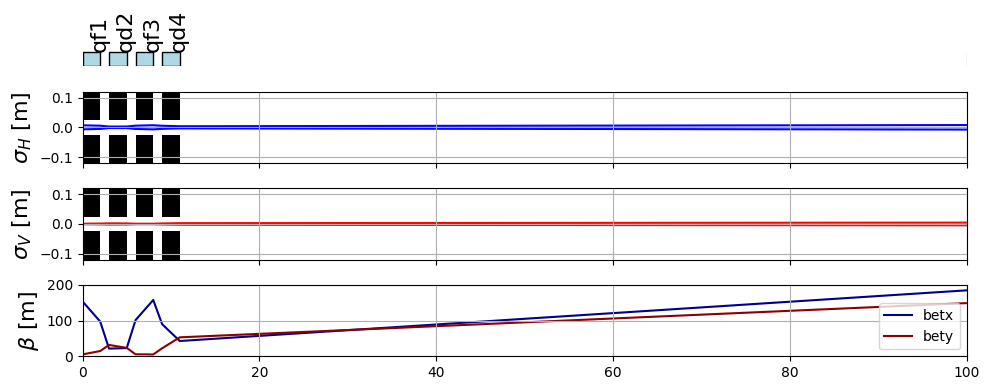

In [11]:
madx.input("kQF1 = "+str(soln.x[0])+";")
madx.input("kQD2 = "+str(soln.x[1])+";")
madx.input("kQF3 = "+str(soln.x[2])+";")
madx.input("kQD4 = "+str(soln.x[3])+";")
twiss = madx.twiss(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, Dx=Dx0, Dy=Dy0, Dpx=Dpx0, Dpy=Dpy0).dframe()

fontsize = 16

fig, ax = plt.subplots(4,1, figsize=(10,4), tight_layout=True, sharex=True, height_ratios=[1,3,3,3])

draw_synoptic(ax[0], twiss)
ax[0].set_xlim(0,twiss.s[-1])
ax[0].set_ylim(-0.02,1.)
ax[0].axis("off")

ax[1].plot(twiss['s'], beam_size(twiss['betx'], twiss['dx'], ex, sige, 1)+twiss.x, alpha=1.0, color ="b", zorder=0)
ax[1].plot(twiss['s'], -beam_size(twiss['betx'], twiss['dx'], ex, sige, 1)+twiss.x, alpha=1.0, color ="b", zorder=0)
draw_aperture_circle(ax[1], twiss, "aper_1")
draw_aperture_rectangle(ax[1], twiss, "aper_1")
ax[1].set_xlim(0,twiss.s[-1])

ax[2].plot(twiss['s'], beam_size(twiss['bety'], twiss['dy'], ey, sige, 1)+twiss.y, alpha=1.0, color ="r", zorder=0)
ax[2].plot(twiss['s'], -beam_size(twiss['bety'], twiss['dy'], ey, sige, 1)+twiss.y, alpha=1.0, color ="r", zorder=0)
draw_aperture_circle(ax[2], twiss, "aper_1")
draw_aperture_rectangle(ax[2], twiss, "aper_2")
ax[2].set_xlim(0,twiss.s[-1])

ax[1].grid()
ax[1].set_ylim(-0.12, 0.12)
ax[1].set_ylabel(r"$\sigma_{H}$ [m]", fontsize=fontsize)

ax[2].grid()
ax[2].set_ylim(-0.12, 0.12)
ax[2].set_ylabel(r"$\sigma_{V}$ [m]", fontsize=fontsize)

# Beta
ax[3].plot(twiss.s, twiss.betx, alpha=1.0, color ="darkblue", zorder=0, label="betx")
ax[3].plot(twiss.s, twiss.bety, alpha=1.0, color ="darkred", zorder=0, label="bety")
ax[3].set_xlim(0,twiss.s[-1])

ax[3].legend()
ax[3].set_ylim(0, 200)
ax[3].grid()
ax[3].set_ylabel(r"$\beta$ [m]", fontsize=fontsize)